In [5]:
import ivtmetrics
import sys
sys.path.append("..")
import dataloader
from torch.utils.data import DataLoader
import os
import csv
import numpy as np
import random
import json
import matplotlib.pyplot as plt
from PIL import Image

In [6]:
metrics = ivtmetrics.Recognition(num_class=100)

In [7]:
dict_path = "/Users/abhivansh/Desktop/bh25/CholecT50/dict"
with open(os.path.join(dict_path, 'triplet.txt'),'r') as f:
    triplet_info = f.readlines()
    triplet_dict = {}
    for l in triplet_info:
        triplet_id, triplet_label = l.split(":")
        triplet_dict[int(triplet_id)]= triplet_label.rstrip()
print("Random triplet id and its human readable label\n")
random_triplet_id = random.choice(list(triplet_dict.keys()))
print("triplet id: ",random_triplet_id)
print("triplet label: ",triplet_dict[random_triplet_id])

Random triplet id and its human readable label

triplet id:  43
triplet label:  bipolar,retract,gallbladder


In [11]:
def generator(data_path, triplet_path, video_names, batch_size, shuffle_videos=False):

  if shuffle_videos:
    video_names = np.random.shuffle(video_names)

  image_batch, triplet_batch, video_name_batch, frame_id_batch = [], [], [], []

  for video_name in video_names:
    with open(os.path.join(triplet_path, video_name + '.json'), mode='r') as infile:
      reader = csv.reader(infile)

      for line in reader:
        line = np.array(line, np.int64)
        frame_id, triplet_label = line[0], line[1:]
        image_path = os.path.join(data_path, video_name, "%06d.png" % frame_id)
        image = np.array(Image.open(image_path), np.float32) / 255.0

        image_batch.append(image)
        triplet_batch.append(triplet_label)
        video_name_batch.append(video_name)
        frame_id_batch.append(int(frame_id))

        if len(frame_id_batch) == batch_size:
          yield image_batch, triplet_batch, video_name_batch, frame_id_batch
          image_batch, triplet_batch, video_name_batch, frame_id_batch = [], [], [], []

In [19]:
import pandas as pd
df = pd.read_json('/Users/abhivansh/Desktop/bh25/CholecT50/labels/VID01.json')
df.info

/var/folders/d_/ll1s1g5d5qn4v9bgwkxq9ddr0000gn/T/ipykernel_50132/3680019686.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json('/Users/abhivansh/Desktop/bh25/CholecT50/labels/VID01.json')
/var/folders/d_/ll1s1g5d5qn4v9bgwkxq9ddr0000gn/T/ipykernel_50132/3680019686.py:2: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  df = pd.read_json('/Users/abhivansh/Desktop/bh25/CholecT50/labels/VID01.json')
/var/folders/d_/ll1s1g5d5qn4v9bgwkxq9ddr0000gn/T/ipykernel_50132/3680019

<bound method DataFrame.info of                                                   annotations  fps licenses  \
0           [[7, 0, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, -1...    1      NaN   
1           [[7, 0, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, -1...    1      NaN   
2           [[7, 0, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, -1...    1      NaN   
3           [[7, 0, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, -1...    1      NaN   
4           [[7, 0, 1, -1, -1, -1, -1, 0, 0, 1, -1, -1, -1...    1      NaN   
...                                                       ...  ...      ...   
instrument                                                NaN    1      NaN   
verb                                                      NaN    1      NaN   
target                                                    NaN    1      NaN   
triplet                                                   NaN    1      NaN   
phase                                                     NaN    1      NaN   

           info    

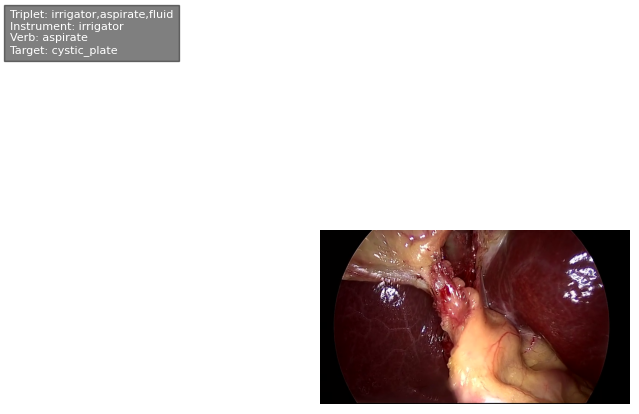

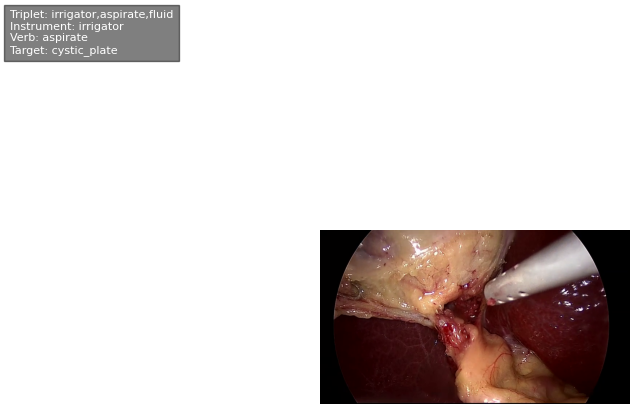

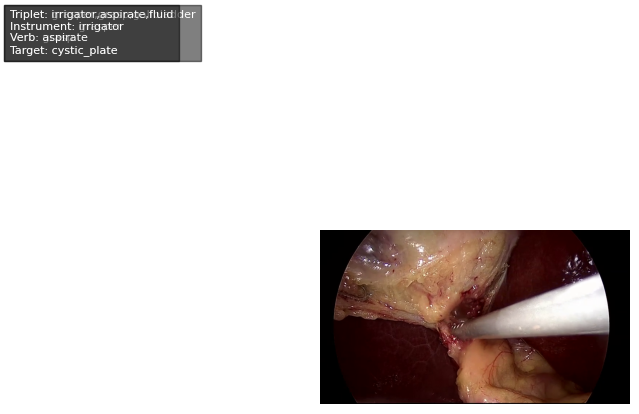

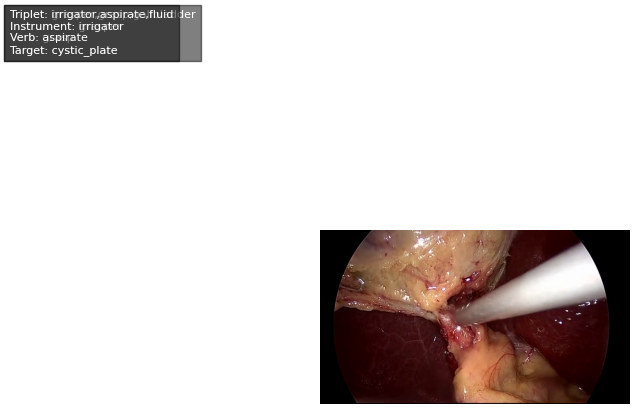

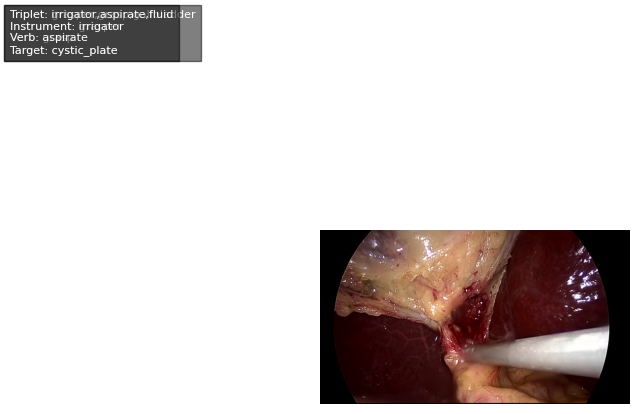

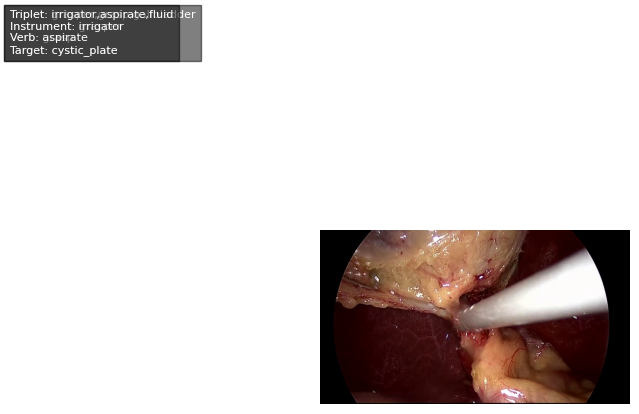

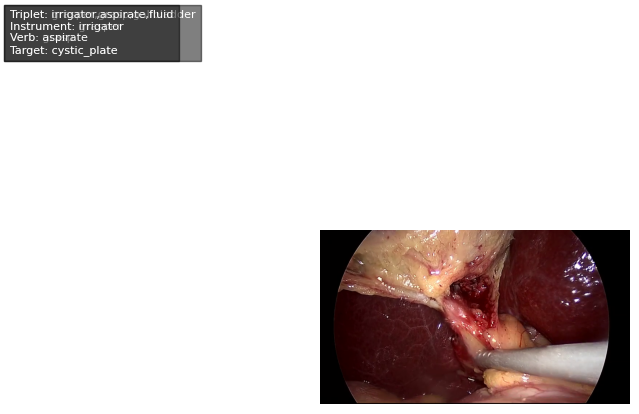

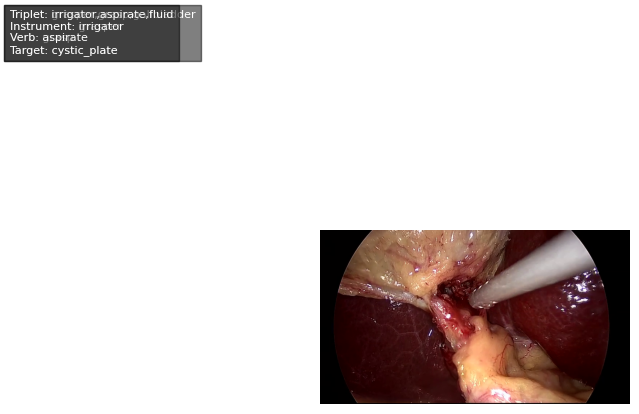

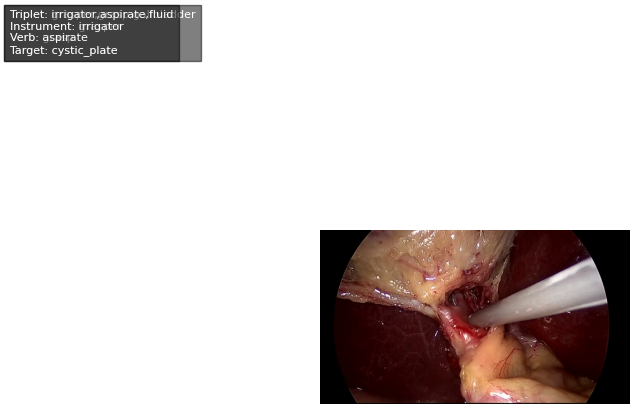

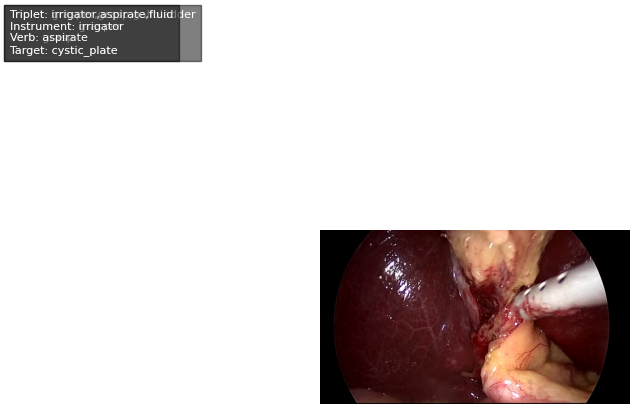

In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def load_json_labels(json_path):
    with open(json_path, 'r') as file:
        data = json.load(file)
    return data

def get_frame_annotations(json_data, frame_id):
    return json_data["annotations"].get(str(frame_id), [])

def plot_frame_with_annotations(image_path, annotations, json_data):
    image = np.array(Image.open(image_path))
    plt.figure(figsize=(4,4))
    plt.imshow(image)
    plt.axis("off")
    
    for annotation in annotations:
        triplet_id = annotation[0]
        instrument_id = annotation[1]
        verb_id = annotation[7]
        target_id = annotation[14]
        bx, by, bw, bh = annotation[10:14]

        h, w, _ = image.shape
        x1, y1, x2, y2 = int(bx * w), int(by * h), int((bx + bw) * w), int((by + bh) * h)
        plt.gca().add_patch(
            plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', facecolor='none', lw=2)
        )
        
        triplet_text = (
            f"Triplet: {json_data['categories']['triplet'].get(str(triplet_id), 'Unknown')}\n"
            f"Instrument: {json_data['categories']['instrument'].get(str(instrument_id), 'Unknown')}\n"
            f"Verb: {json_data['categories']['verb'].get(str(verb_id), 'Unknown')}\n"
            f"Target: {json_data['categories']['target'].get(str(target_id), 'Unknown')}"
        )
        plt.text(x1, y1 - 10, triplet_text, color='white', fontsize=8, bbox=dict(facecolor='black', alpha=0.5))
    
    plt.show()

def visualize_video(json_path, image_folder, frame_range):
    json_data = load_json_labels(json_path)
    
    for frame_id in frame_range:
        frame_annotations = get_frame_annotations(json_data, frame_id)
        image_path = os.path.join(image_folder, f"{frame_id:06d}.png")
        
        if os.path.exists(image_path):
            plot_frame_with_annotations(image_path, frame_annotations, json_data)
        else:
            print(f"Frame {frame_id:06d} not found.")

json_path = "/Users/abhivansh/Desktop/bh25/CholecT50/labels/VID01.json"
image_folder = "/Users/abhivansh/Desktop/bh25/CholecT50/videos/VID01"
frame_range = range(300, 310)

visualize_video(json_path, image_folder, frame_range)